## CS6700: Reinforcement Learning - Tutorial 4 (Q-Learning and SARSA)

Your tasks are as follows:

1. Complete code for $\epsilon$-greedy and softmax action selection policy
2. Complete update equation for SARSA - train and visualize an agent
3. Analyze performance of SARSA - Plot total reward & steps taken per episode (averaged across 5 runs)
4. Complete update equation for Q-Learning - train and visualize an agent
5. Analyze performance of Q-Learning - Plot total reward & steps taken per episode (averaged across 5 runs)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline

# Problem Statement

In this section we will implement tabular SARSA and Q-learning algorithms for a grid world navigation task.

## Environment details
The agent can move from one grid coordinate to one of its adjacent grids using one of the four actions: UP, DOWN, LEFT and RIGHT. The goal is to go from a randomly assigned starting position to goal position.

Actions that can result in taking the agent off the grid will not yield any effect.
Lets look at the environment.


In [3]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

Let us construct a grid in a text file.

In [4]:
!cat grid_world2.txt

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


This is a $17\times 23$ grid. The reward when an agent goes to a cell is negative of the value in that position in the text file (except if it is the goal cell). We will define the goal reward as 100. We will also fix the maximum episode length to 10000.

Now let's make it more difficult. We add stochasticity to the environment: with probability 0.2 agent takes a random action (which can be other than the chosen action).
There is also a westerly wind blowing (to the right). Hence, after every time-step, with probability 0.5 the agent also moves an extra step to the right.

Now let's plot the grid world.

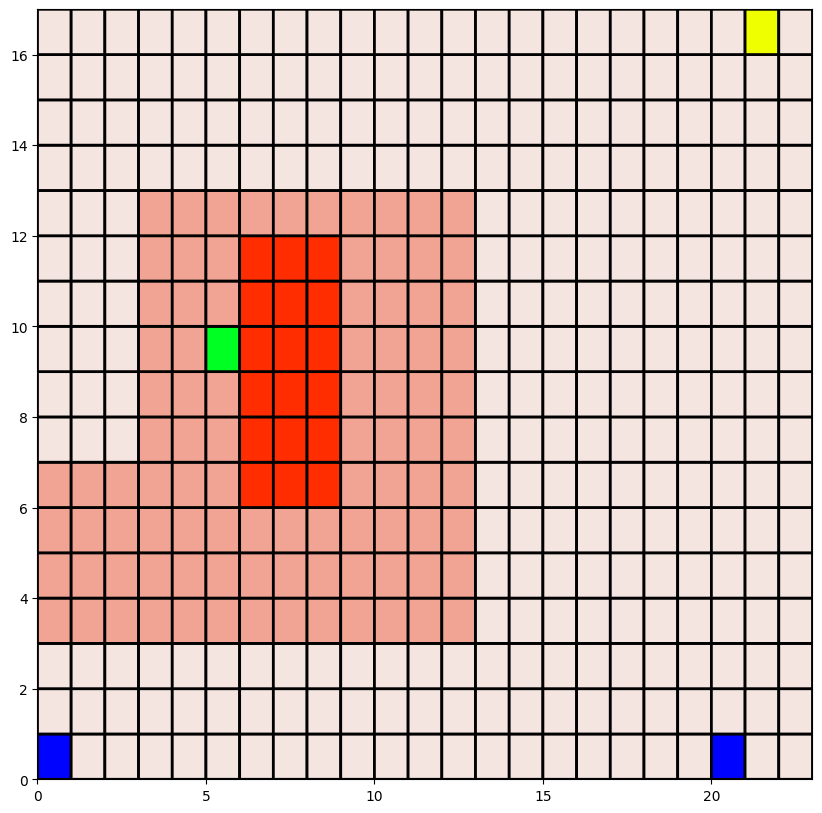

In [5]:
world = 'grid_world2.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

### Legend
- <span style="color:#0004FF">*Blue*</span> is the **start state**.
- <span style="color:#00FF23">*Green*</span> is the **goal state**.
- <span style="color:#F0FF00">*Yellow*</span> is current **state of the agent**.
- <span style="color:#FF2D00">*Redness*</span> denotes the extent of **negative reward**.

### Q values
We can use a 3D array to represent Q values. The first two indices are X, Y coordinates and last index is the action.

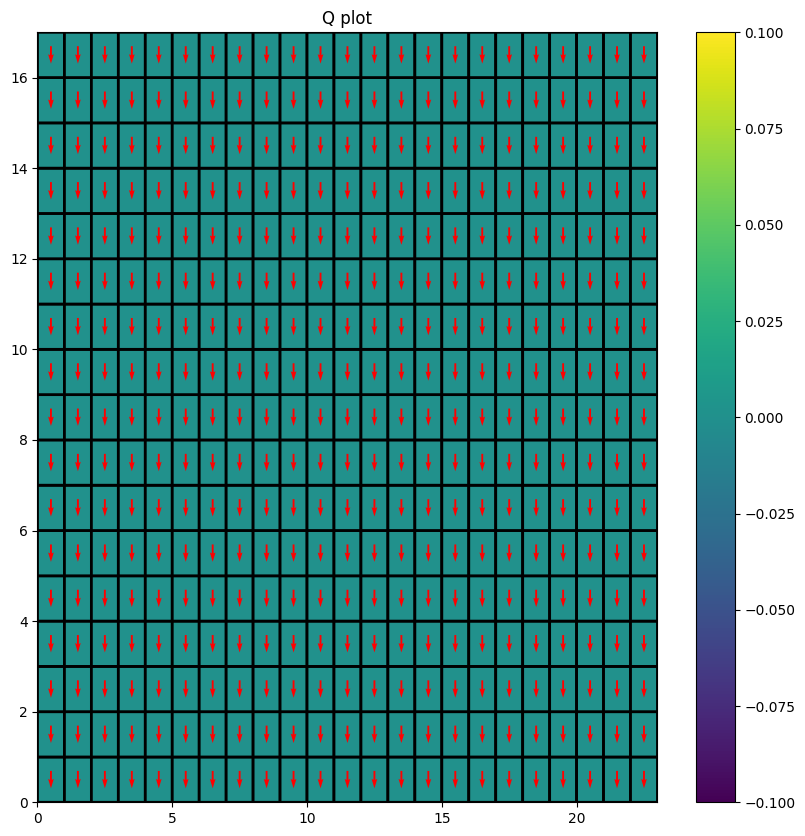

(17, 23, 4)

In [6]:
from grid_world import plot_Q

Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

plot_Q(Q)

Q.shape

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [9]:
#from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if not Q[state[0], state[1]].any(): #If all actions in state(x,y) have 0 Q-values:
        return np.random.choice(actions) # return random action
    else:
        Q_values = Q[state[0],state[1]]
        best_action = Q_values.argmax()
        chosen_action = None
        random_value = rg.rand() #Random value between 0 and 1
        if random_value <= epsilon: #Choose any other arm
            remaining_actions = actions.copy()
            remaining_actions.remove(best_action)
            chosen_action = rg.choice(remaining_actions)
        else:
            chosen_action = best_action
        return chosen_action #return best action

# Softmax
def choose_action_softmax(Q, state, rg=rg):
    tau = 1.0
    q_values = Q[state[0],state[1]]
    max_value = np.max(q_values)
    preferences = np.exp((q_values-max_value)/tau) #Normalized by max q-value
    probabilites = preferences/np.sum(preferences)
    chosen_action = rg.choice(actions,p=probabilites)
    return chosen_action # return random action with selection probability

## SARSA
Now we implement the SARSA algorithm.

Recall the update rule for SARSA:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have som hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

In [11]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

Let's implement SARSA

In [17]:
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        if choose_action == choose_action_epsilon:
            action = choose_action(Q, state,epsilon0)
        else:
            action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            if choose_action == choose_action_epsilon:
                action_next = choose_action(Q, state_next,epsilon0)
            else:
                action_next = choose_action(Q, state_next)

            #update equation
            Q[state[0],state[1],action] += alpha0 * (reward + gamma*Q[state_next[0],state_next[1],action_next] -
                                                     Q[state[0],state[1],action])
                                       
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

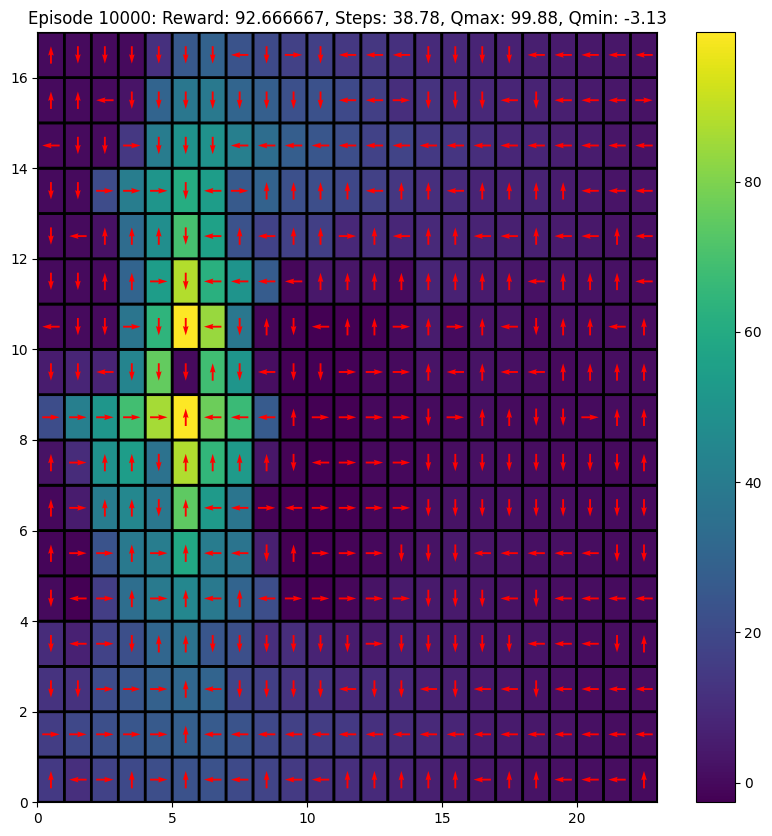

100%|██████████| 10000/10000 [01:12<00:00, 137.71it/s]


In [13]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

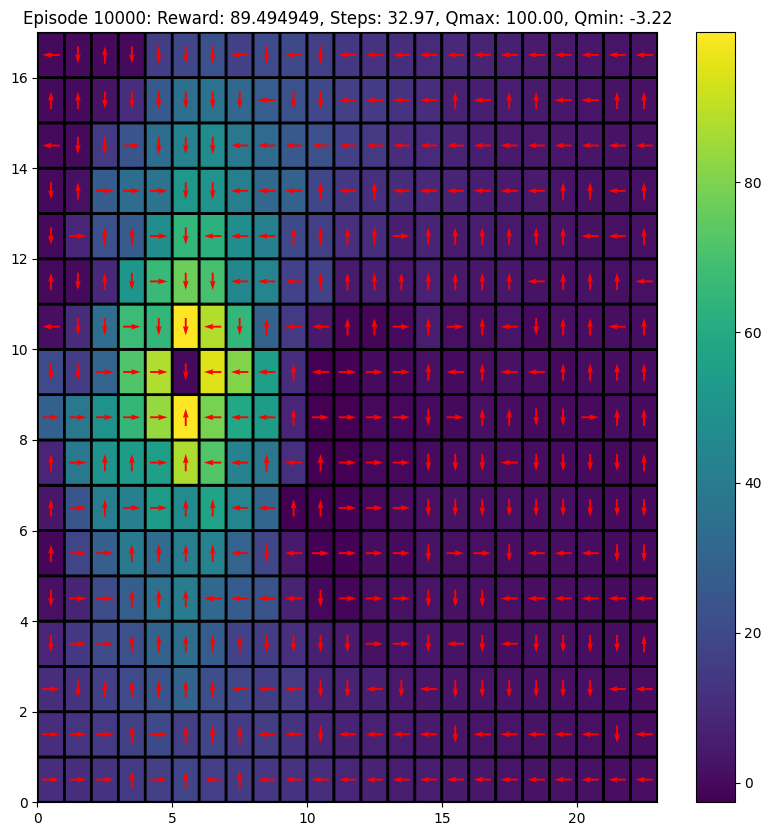

100%|██████████| 10000/10000 [00:46<00:00, 213.62it/s]


In [18]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_epsilon)

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

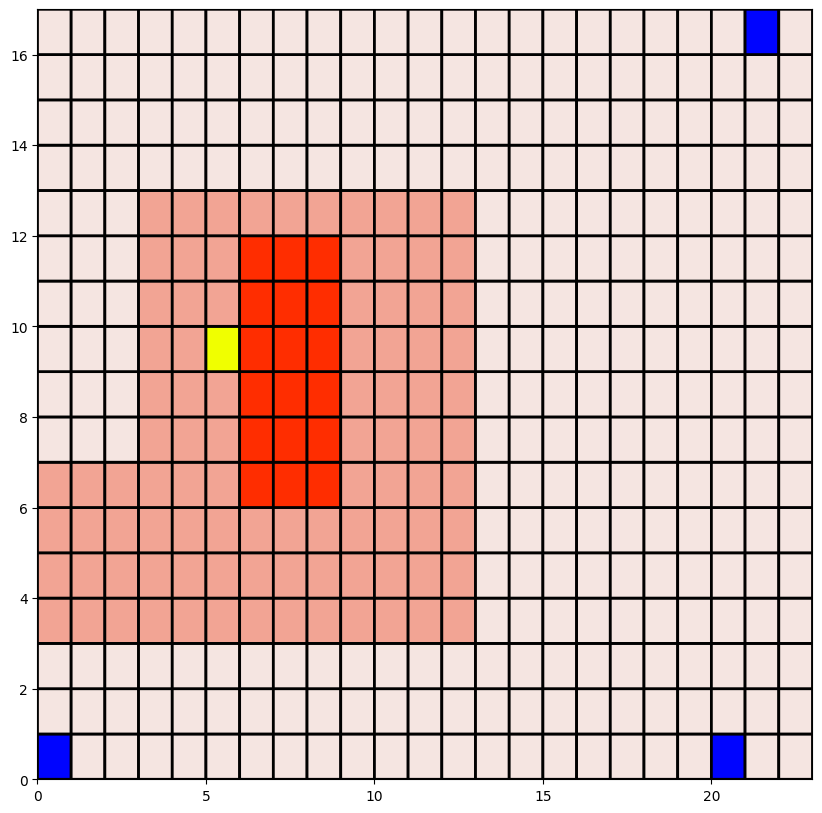

Steps: 29, Total Reward: 95


In [20]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy
We use two metrics to analyze the policies:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

    Experiment : Softmax

In [24]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    # TODO: run sarsa, store metrics
    Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

average_rewards = sum(reward_avgs)/len(reward_avgs)
average_steps = sum(steps_avgs)/len(steps_avgs)

Experiment: 1


100%|██████████| 10000/10000 [00:49<00:00, 203.33it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:35<00:00, 283.49it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:34<00:00, 288.66it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:45<00:00, 220.94it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:39<00:00, 252.25it/s]


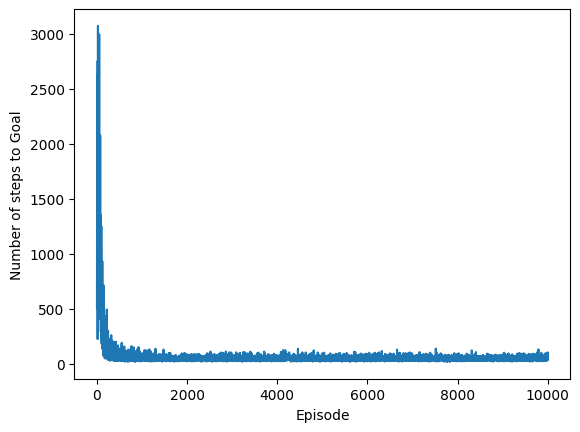

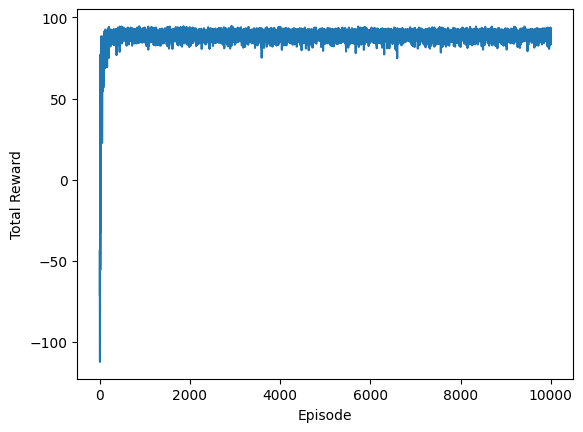

In [34]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

plt.figure()
plt.plot(np.arange(1,episodes + 1),average_steps)
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.show()

plt.figure()
plt.plot(np.arange(1,episodes + 1),average_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

    Experiment : Epsilon-Greedy

In [49]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    # TODO: run sarsa, store metrics
    Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_epsilon)
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

average_rewards = sum(reward_avgs)/len(reward_avgs)
average_steps = sum(steps_avgs)/len(steps_avgs)

Experiment: 1


100%|██████████| 10000/10000 [29:41<00:00,  5.61it/s]


Experiment: 2


 77%|███████▋  | 7734/10000 [21:14<06:13,  6.07it/s]


KeyboardInterrupt: 

In [ ]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

plt.figure()
plt.plot(np.arange(1,episodes + 1),average_steps)
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.show()

plt.figure()
plt.plot(np.arange(1,episodes + 1),average_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

## Q-Learning
Now, implement the Q-Learning algorithm as an exercise.

Recall the update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

Visualize and compare results with SARSA.

In [35]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

In [36]:
print_freq = 100

def qlearning(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)
            
            # TODO: update equation 
            Q[state[0],state[1],action] += alpha0 * (reward + gamma * np.max(Q[state_next[0],state_next[1]])
                                                     - Q[state[0],state[1],action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

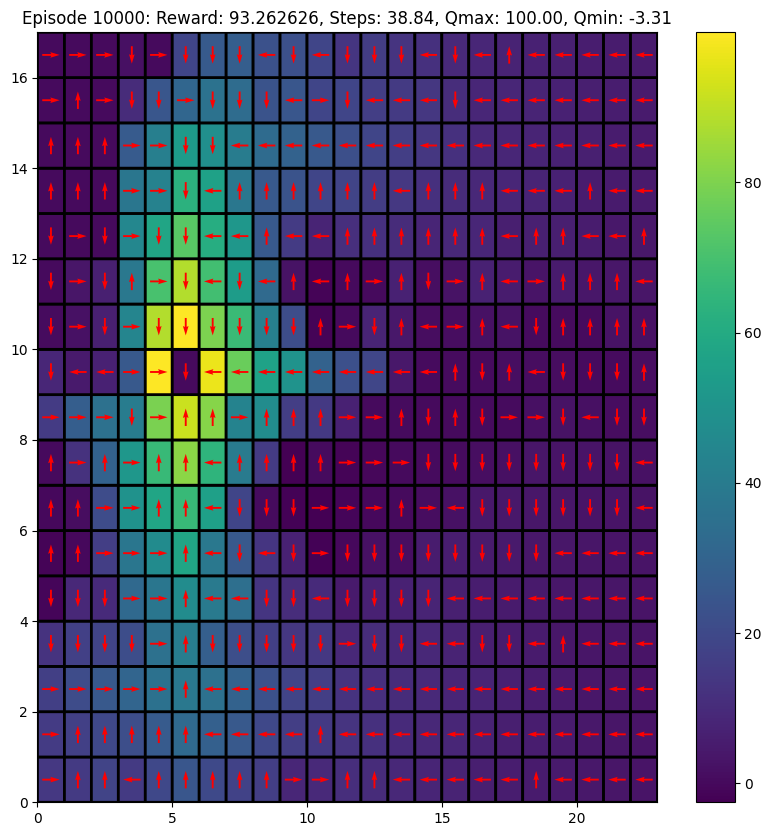

100%|██████████| 10000/10000 [01:09<00:00, 144.69it/s]


In [37]:
Q, rewards, steps = qlearning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

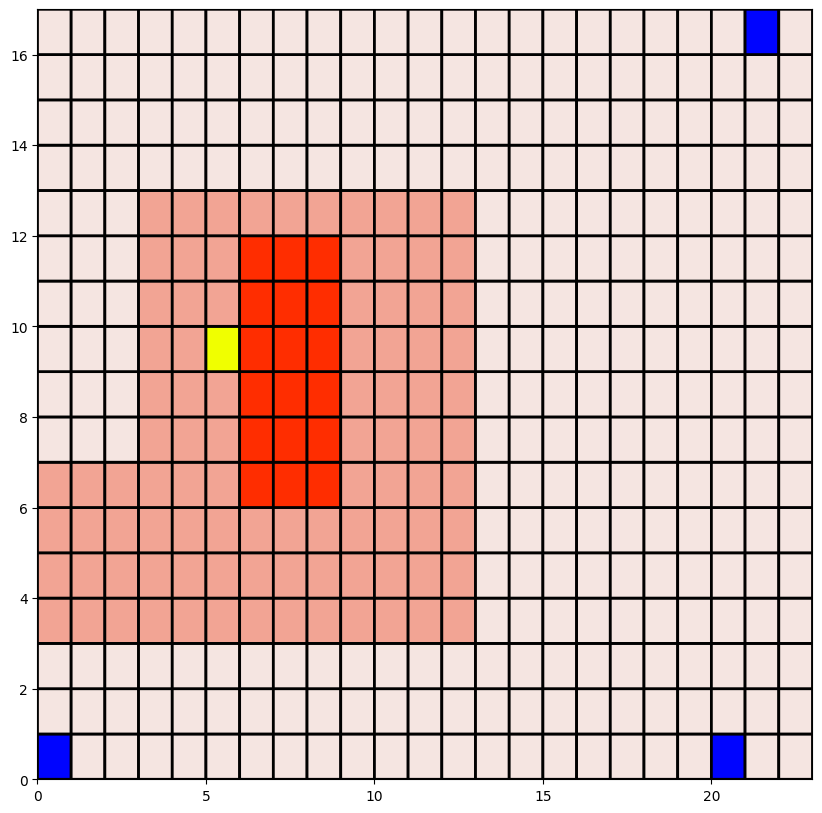

Steps: 20, Total Reward: 89


In [40]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

In [41]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)

    # TODO: run qlearning, store metrics
    Q, rewards, steps = qlearning(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

average_rewards = sum(reward_avgs)/len(reward_avgs)
average_steps = sum(steps_avgs)/len(steps_avgs)

Experiment: 1


100%|██████████| 10000/10000 [00:37<00:00, 266.42it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:33<00:00, 298.28it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:32<00:00, 305.31it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:36<00:00, 277.43it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:42<00:00, 237.21it/s]


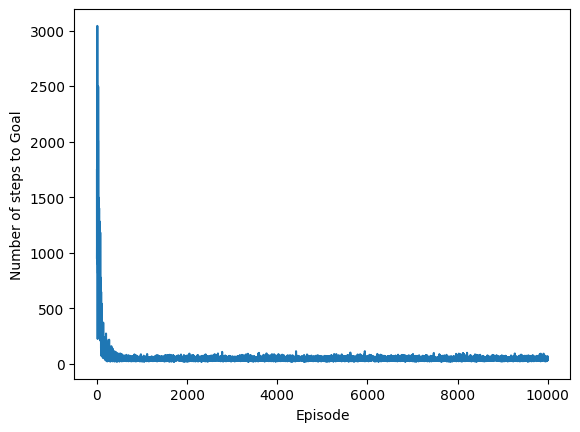

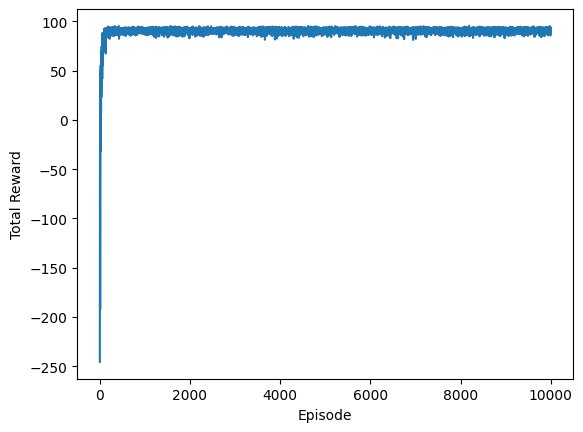

In [42]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

plt.figure()
plt.plot(np.arange(1,episodes + 1),average_steps)
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.show()

plt.figure()
plt.plot(np.arange(1,episodes + 1),average_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

### TODO: What differences do you observe between the policies learnt by Q Learning and SARSA (if any). 

SARSA gives a lesser reward than Q-Learning for a majority of episodes, until the end where the rewards obtained are similar. Q-learning reaches its mininum steps count much earlier at around 1000 episodes, while SARSA takes 2000 episodes to reach the same step count.

There is much more "noise" in the rewards obtained by SARSA in the later episodes, not being as stable as Q-learning, which has relatively consistant rewards towards the end.

In [45]:
%pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Password:
sudo: a password is required


In [47]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/CS6700_Tutorial_4_QLearning_ED21B051.ipynb"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/CS6700_Tutorial_4_QLearning_ED21B051.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.